# Dependencies

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import time
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import torchvision.transforms as transforms
from datasets import camvid
from datasets import joint_transforms
import utils.imgs
import utils.training as train_utils
from models import tiramisu


# Data

In [ ]:
#!git clone https://github.com/alexgkendall/SegNet-Tutorial

Cloning into 'SegNet-Tutorial'...
Updating files:  88% (1276/1445)
Updating files:  89% (1287/1445)
Updating files:  90% (1301/1445)
Updating files:  91% (1315/1445)
Updating files:  92% (1330/1445)
Updating files:  93% (1344/1445)
Updating files:  94% (1359/1445)
Updating files:  95% (1373/1445)
Updating files:  96% (1388/1445)
Updating files:  97% (1402/1445)
Updating files:  98% (1417/1445)
Updating files:  99% (1431/1445)
Updating files: 100% (1445/1445)
Updating files: 100% (1445/1445), done.


In [4]:
CAMVID_PATH = Path('SegNet-Tutorial/CamVid')
RESULTS_PATH = Path('.results/')
WEIGHTS_PATH = Path('.weights/')
RESULTS_PATH.mkdir(exist_ok=True)
WEIGHTS_PATH.mkdir(exist_ok=True)
batch_size = 2

In [5]:
normalize = transforms.Normalize(mean=camvid.mean, std=camvid.std)
train_joint_transformer = transforms.Compose([
    joint_transforms.JointRandomCrop(224), # crop 224-by-224 section
    joint_transforms.JointRandomHorizontalFlip() # flip with 50% probability
])

train_dset = camvid.CamVid(CAMVID_PATH, 'train',
      joint_transform=train_joint_transformer,
      transform=transforms.Compose([
          transforms.ToTensor(),
          normalize,
    ]))
train_loader = torch.utils.data.DataLoader(train_dset, batch_size=batch_size, shuffle=True)

val_dset = camvid.CamVid(
    CAMVID_PATH, 'val', joint_transform=None,
    transform=transforms.Compose([
        transforms.ToTensor(),
        normalize
    ]))
val_loader = torch.utils.data.DataLoader(
    val_dset, batch_size=batch_size, shuffle=False)

test_dset = camvid.CamVid(
    CAMVID_PATH, 'test', joint_transform=None,
    transform=transforms.Compose([
        transforms.ToTensor(),
        normalize
    ]))
test_loader = torch.utils.data.DataLoader(
    test_dset, batch_size=batch_size, shuffle=False)

Train: 367
Val: 101
Test: 233
Classes: 12
Inputs:  torch.Size([2, 3, 224, 224])
Targets:  torch.Size([2, 224, 224])


c:\Users\trans\source\repos\pytorch_tiramisu\datasets\camvid.py:55: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  label = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))


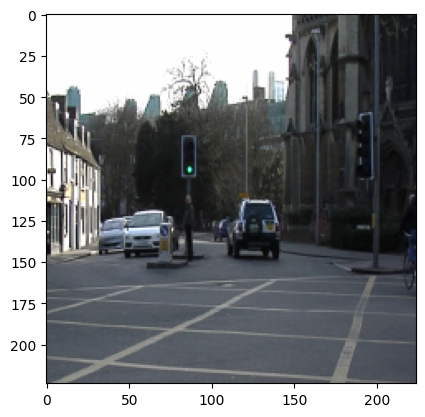

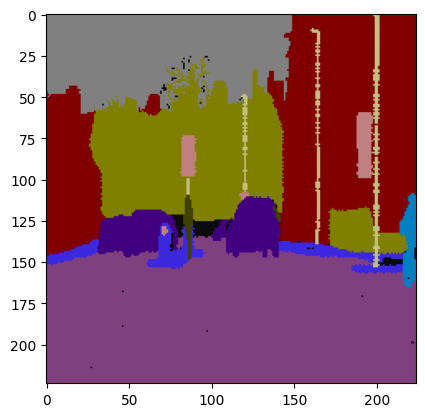

In [6]:
print("Train: %d" %len(train_loader.dataset.imgs))
print("Val: %d" %len(val_loader.dataset.imgs))
print("Test: %d" %len(test_loader.dataset.imgs))
print("Classes: %d" % len(train_loader.dataset.classes))

inputs, targets = next(iter(train_loader))
print("Inputs: ", inputs.size())
print("Targets: ", targets.size())

utils.imgs.view_image(inputs[0])
utils.imgs.view_annotated(targets[0])

# Train

In [13]:
LR = 1e-3 # 1e-4 for fine-tuning
LR_DECAY = 0.995 # LR is multiplied by this after every epoch
DECAY_EVERY_N_EPOCHS = 1
N_EPOCHS = 10
torch.cuda.manual_seed(0)

Define the model

In [14]:
model = tiramisu.FCDenseNet67(n_classes=12).cuda()
model.apply(train_utils.weights_init)
optimizer = torch.optim.RMSprop(model.parameters(), lr=LR, weight_decay=1e-4)
criterion = nn.NLLLoss(weight=camvid.class_weight.cuda()).cuda() # compares model prediction to actual data

In [9]:
model.state_dict()

OrderedDict([('firstconv.weight',
              tensor([[[[-9.5180e-02,  1.5725e-02, -4.4790e-01],
                        [ 4.1491e-01,  4.2036e-01,  2.7976e-01],
                        [-8.0125e-02,  3.0194e-01, -2.5546e-01]],
              
                       [[ 3.8616e-01, -3.5984e-01, -4.0048e-01],
                        [-8.5587e-02,  4.3376e-01, -2.7407e-01],
                        [-2.8854e-01,  3.6859e-01, -5.7824e-02]],
              
                       [[-1.3484e-01,  4.2774e-02,  3.1105e-01],
                        [-2.7347e-01,  2.5307e-01, -6.6946e-02],
                        [-2.7184e-01,  1.5137e-01, -3.1550e-01]]],
              
              
                      [[[-7.0717e-02,  4.6449e-01,  1.8519e-01],
                        [-2.3836e-01,  1.9121e-01,  2.3514e-01],
                        [ 4.0568e-01, -4.2480e-01, -4.0069e-01]],
              
                       [[ 2.0955e-01,  4.2220e-01, -1.2760e-01],
                        [-2.6258e-01,  2.

In [ ]:
for epoch in range(1, N_EPOCHS+1):
    since = time.time()

    ### Train ###
    trn_loss, trn_err = train_utils.train(
        model, train_loader, optimizer, criterion, epoch)
    print('Epoch {:d}\nTrain - Loss: {:.4f}, Acc: {:.4f}'.format(
        epoch, trn_loss, 1-trn_err))    
    time_elapsed = time.time() - since  
    print('Train Time {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    ### Test ###
    val_loss, val_err = train_utils.test(model, val_loader, criterion, epoch)    
    print('Val - Loss: {:.4f} | Acc: {:.4f}'.format(val_loss, 1-val_err))
    time_elapsed = time.time() - since  
    print('Total Time {:.0f}m {:.0f}s\n'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    ### Checkpoint ###    
    train_utils.save_weights(model, epoch, val_loss, val_err)

    ### Adjust Lr ###
    train_utils.adjust_learning_rate(LR, LR_DECAY, optimizer, 
                                     epoch, DECAY_EVERY_N_EPOCHS)

# lab PC finished 10 epochs in 89m with loss of 1.3

Epoch 1
Train - Loss: 3.6244, Acc: 0.4242
Train Time 1m 0s
Val - Loss: 2.1858 | Acc: 0.4968
Total Time 8m 55s

Epoch 2
Train - Loss: 1.9034, Acc: 0.4845
Train Time 1m 1s
Val - Loss: 1.8109 | Acc: 0.5405
Total Time 8m 55s

Epoch 3
Train - Loss: 1.8286, Acc: 0.4847
Train Time 1m 1s
Val - Loss: 2.0200 | Acc: 0.4065
Total Time 8m 54s

Epoch 4
Train - Loss: 1.6953, Acc: 0.5166
Train Time 1m 2s
Val - Loss: 1.7332 | Acc: 0.5400
Total Time 8m 56s

Epoch 5
Train - Loss: 1.6121, Acc: 0.5410
Train Time 1m 1s
Val - Loss: 1.7184 | Acc: 0.5367
Total Time 8m 54s

Epoch 6
Train - Loss: 1.4647, Acc: 0.5703
Train Time 1m 1s
Val - Loss: 1.6072 | Acc: 0.5546
Total Time 8m 58s

Epoch 7
Train - Loss: 1.3878, Acc: 0.6019
Train Time 1m 3s
Val - Loss: 1.6256 | Acc: 0.5601
Total Time 8m 56s

Epoch 8
Train - Loss: 1.3095, Acc: 0.6163
Train Time 1m 1s
Val - Loss: 1.3729 | Acc: 0.5504
Total Time 8m 53s

Epoch 9
Train - Loss: 1.2825, Acc: 0.6243
Train Time 1m 2s
Val - Loss: 1.8203 | Acc: 0.5061
Total Time 8m 54s

E

In [12]:
train_utils.test(model, test_loader, criterion, epoch=1)  

(1.7229648064344356, 0.5434956410256411)